# Energy Label Transition Model - Base model

**This notebook provides a working skeleton to start your modelling project from**


## 0. About the Model

### Model Narrative
This agent-based model simulates the adoption of energy efficiency improvements among homeowners in a city. **Owners** are autonomous agents who evaluate whether to upgrade their house's energy label based on their financial capacity. **Houses** are passive agents that maintain their energy efficiency rating (ranging from G, the worst, to A+, the best). This base model explores how financial constraints influence the rate and pattern of energy efficiency transitions over time, providing insights into policy interventions that could accelerate sustainable housing improvements.


### How to use this Model
This base model provides a minimal working skeleton. The choices made in this model are primitive. You should replace them with logic that better fits your research question and ideas. For example, the use of grid space is provided as a simplified example; you might want to consider a more realistic network structure instead. 

## 1. Import Libraries

Import the necessary libraries for the agent-based model.

In [233]:
# Core Mesa library for agent-based modeling
import mesa

# Numerical and data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Random
import random

# Type hints for better code documentation
from typing import Dict, List, Tuple

# Print Mesa version to confirm correct installation
print(f"Mesa version: {mesa.__version__}")
print("Required: Mesa 3.0.3 or higher")   


Mesa version: 3.3.1
Required: Mesa 3.0.3 or higher


## 2. Functions

These functions provide basic model mechanics using simple linear relationships as examples. You can also decide to remove them from the model and replace them with different functions that better suit your ideas.

In [234]:
def label_to_numeric(label: str) -> int:
    """Convert energy label to numeric value (G=0 to A+=7)."""
    # Dictionary mapping letter labels to numbers for calculations
    mapping = {"G": 0, "F": 1, "E": 2, "D": 3, "C": 4, "B": 5, "A": 6, "A+": 7}
    return mapping.get(label, 0)  # Return 0 if label not found


def numeric_to_label(value: float) -> str:
    """Convert numeric value back to energy label string."""
    # Dictionary mapping numbers back to letter labels
    mapping = {0: "G", 1: "F", 2: "E", 3: "D", 4: "C", 5: "B", 6: "A", 7: "A+"}
    rounded = int(round(value))  # Round to nearest integer
    rounded = max(0, min(7, rounded))  # Clamp to valid range [0, 7]
    return mapping[rounded] # This returns the corresponding label


def calculate_transition_cost(current_label: str, target_label: str) -> float:
    """Calculate cost to transition from current to target label.
    
    Simple linear cost model: 10,000€ per label step improvement.
    Example: D→B costs 20,000€ (2 steps × 10,000€)
    """
    # Calculate how many label steps need to be improved
    gap = label_to_numeric(target_label) - label_to_numeric(current_label)
    
    # If already at or above target, no cost needed
    if gap <= 0:
        return 0.0
    
    # Linear cost: €10,000 per label step
    return gap * 10000

def calculate_house_satisfaction(current_label: str, market_value: str, energy_label_pref: float, market_value_pref: float):
    """Calculate the house satisfaction based on the current_label and the market_value."""

    house_satisfaction = label_to_numeric(current_label) * energy_label_pref + market_value * market_value_pref
    
    return house_satisfaction

def calculate_max_label_upgrade(financial_status: int, current_label: str):
    """Calculate the maximum label upgrade possible with the financial status."""

    label_steps = max(financial_status, 0) // 10000 # check the number of label_steps possible with the financial status

    max_label = label_to_numeric(current_label) + label_steps

    if max_label > 7:
        max_label = 7
    
    return numeric_to_label(max_label)

def normal_between_0_and_1(mu=0.5, sigma=0.15):
    x = random.gauss(mu, sigma)
    return min(max(x, 0.0), 1.0)

def calculate_max_value_upgrade(financial_status: int, market_value_current: float):
    value_steps = max(financial_status, 0) // 10000

    max_value = market_value_current + value_steps

    return max_value

def calculate_neighbour_chillness(self):
            x, y = self.house.pos
            neighbours = self.model.grid.get_neighbors((x, y), moore=True, include_center=False)
            neighbours_chillness = [
                agent.chillness for agent in neighbours
                if isinstance(agent, Owner)]

            if not neighbours_chillness:
                return 0.5 #0.5 is considered neutral
            
            return sum(neighbours_chillness) / len(neighbours_chillness)

## 3. House Class

Houses are Mesa agents fixed at grid positions with energy efficiency labels.

**Key Points:**
- Houses inherit from `mesa.Agent` to enable grid placement and data collection
- Houses are **passive** - they don't make decisions
- Each grid cell can have at most one house
- Houses can be vacant (no owner) or occupied

In [235]:
class House(mesa.Agent):
    """House agent - passive container for energy efficiency information."""

    def __init__(self, model, current_label: str):
        super().__init__(model)  # Initialize Mesa Agent. Note that mesa will assign a unique ID to each agent instance
        self.current_label = current_label  # Energy label (A+ to G)
        self.owner_id = None  # ID of owner living here (None if vacant)
    
    def step(self):
        """Houses are passive - no actions needed each time step."""
        pass

## 4. Owner Class

Owners make simple decisions about transitioning.

**Key Points:**
- They can transition house label **ONCE**
- They use simple affordability-based decision

In [236]:
class Owner(mesa.Agent):
    """Homeowner who makes transition decisions."""
    
    def __init__(self, model, financial_status: float, energy_label_pref: float, market_value_pref: float, chillness: float):
        super().__init__(model)  # Initialize Mesa Agent
        self.financial_status = financial_status  # Available budget (€)
        self.energy_label_pref = energy_label_pref
        self.market_value_pref = market_value_pref
        self.chillness = chillness
        self.house = None  # Reference to House object (assigned later)
        self.has_transitioned = 0  # Track if already upgraded
        self.has_moved = 0
        self.has_moved_and_transitioned = 0
    
    def step(self):
        """Called each year - owner decides whether to transition."""

        self.neighbour_chillness = calculate_neighbour_chillness(self) - 0.5

        self.curr_house_sat = calculate_house_satisfaction(
            self.house.current_label, self.house.market_value, self.energy_label_pref, self.market_value_pref) + self.neighbour_chillness
        
        max_label_upgrade = calculate_max_label_upgrade(self.financial_status, self.house.current_label)

        cost = calculate_transition_cost(self.house.current_label, max_label_upgrade)

        # Investigate potential benefits of upgrading the label
        pot_house_sat_upg = calculate_house_satisfaction(
            max_label_upgrade, self.house.market_value, self.energy_label_pref, self.market_value_pref) + self.neighbour_chillness

        # Investigate potential benefits of moving
        max_value = calculate_max_value_upgrade(self.financial_status, self.house.market_value)
        empty_houses_in_budget = [h for h in self.model.agents_by_type[House].select(lambda h: h.owner_id is None and h.market_value <= max_value)]

        pot_house_sat_move = float("-inf")
        self.best_house_move = None

        for house in empty_houses_in_budget:
            moving_satisfaction = calculate_house_satisfaction(
                house.current_label, house.market_value, self.energy_label_pref, self.market_value_pref)
            if moving_satisfaction > pot_house_sat_move:
                pot_house_sat_move = moving_satisfaction
                self.best_house_move = house

        pot_house_sat_move_and_upg = float("-inf")
        self.best_house_move_and_upg = None
        
        for house in empty_houses_in_budget:
            rest_income = self.financial_status + self.house.market_value * 10000 - house.market_value * 10000
            pot_label_upgrade = calculate_max_label_upgrade(rest_income, house.current_label)
            move_and_upgrade_satisfaction = calculate_house_satisfaction(
                pot_label_upgrade, house.market_value, self.energy_label_pref, self.market_value_pref)
            if move_and_upgrade_satisfaction > pot_house_sat_move_and_upg:
                pot_house_sat_move_and_upg = move_and_upgrade_satisfaction
                self.best_house_move_and_upg = house

        max_sat = max(self.curr_house_sat, pot_house_sat_upg, pot_house_sat_move, pot_house_sat_move_and_upg)
        self.wants_to_move = False
        self.wants_to_move_and_upgrade = False

        if self.house is not None and max_sat != self.curr_house_sat:
            if max_sat == pot_house_sat_upg:
                self.financial_status = self.financial_status - cost
                self.curr_house_sat = pot_house_sat_upg
                self.house.current_label = max_label_upgrade
                self.has_transitioned += 1

            elif max_sat == pot_house_sat_move:
                self.wants_to_move = True
            
            elif max_sat == pot_house_sat_move_and_upg:
                self.wants_to_move_and_upgrade = True


## 5. City Model Class

The City model manages the simulation.

**Key Components:**
- Simple grid (10×10) (feel free to change the grid structure or size)
- Includes agents
- Manages the data collection
- Runs the simulation and triggers agent steps

In [237]:
class City(mesa.Model):
    """City model with houses and owners on a grid."""
    
    def __init__(
        self,
        num_houses: int = 50, # Total number of houses in the model
        num_owners: int = 40, # Total number of owners in the model
        grid_size: int = 10, # Size of the grid (grid_size x grid_size). Note that you can define the width and height separately with different dimensions if desired
        financial_status_mean: float = 30000, # Average financial status of owners (€). This helps controlling the affordability of transitions in the base model
        financial_status_std: float = 5000, # Standard deviation of financial status (€). This helps controlling the affordability of transitions in the base model
        label_distribution: Dict[str, float] = None, # Distribution of energy labels among houses. This allows customizing the initial state of the housing stock
        target_label: str = "A", # Target energy label for transitions
        seed: int = None
    ):
        # Initialize Mesa Model with seed (Mesa 3.0 handles random number generation)
        super().__init__(seed=seed)
        
        # Validate inputs. Return an error if the number of owners is greater than the number of houses
        if num_owners > num_houses:
            raise ValueError(f"Cannot have more owners ({num_owners}) than houses ({num_houses})!")
        
        # Assign parameters to model attributes
        self.num_houses = num_houses
        self.num_owners = num_owners
        self.grid_size = grid_size
        self.financial_status_mean = financial_status_mean
        self.financial_status_std = financial_status_std
        self.target_label = target_label
        
        # Default label distribution (more poor labels, fewer good ones). If this line is confusing, please ask teh instructor.
        if label_distribution is None:
            self.label_distribution = {
                "G": 0.05, "F": 0.10, "E": 0.20, "D": 0.30,
                "C": 0.20, "B": 0.10, "A": 0.04, "A+": 0.01
            }
        else:
            self.label_distribution = label_distribution

        # Initialize grid using Mesa's MultiGrid object (please read the documentation for more details)
        self.grid = mesa.space.MultiGrid(grid_size, grid_size, torus=False)
        
        # Create agents
        self.create_houses()
        self.create_owners()

        # Assign houses to owners based on their grid positions
        self.assign_houses_to_owners()
        
        # Set up data collection
        self.setup_data_collection()
        self.datacollector.collect(self)
    
    def compute_location_value(self, pos):
        """Returns a location value between 0 and 1 based on distance to center."""

        x, y = pos

        # geometric center (works for both even and odd grid sizes)
        cx = (self.grid_size - 1) / 2
        cy = (self.grid_size - 1) / 2

        # Euclidean distance to center
        dist = ((x - cx)**2 + (y - cy)**2)**0.5

        # maximum possible distance on the grid (corner to center)
        max_dist = ((cx)**2 + (cy)**2)**0.5

        # normalize: center → 1.0, farthest corner → 0.0
        location_value = 1 - (dist / max_dist)

        return location_value

    def create_houses(self):
        """Create and place houses on grid."""
        # Extract label names and probabilities from distribution
        labels = list(self.label_distribution.keys())
        probs = list(self.label_distribution.values())
        
        # Check if we have enough grid cells for all houses
        total_cells = self.grid_size * self.grid_size
        if self.num_houses > total_cells: #raise error if not enough space
            raise ValueError(f"Cannot place {self.num_houses} houses on a {self.grid_size}×{self.grid_size} grid (only {total_cells} cells available)!")
        
        # Generate all possible grid positions
        all_positions = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size)]
        
        # Sample unique positions without replacement (much more efficient than while loop)
        selected_positions = self.random.sample(all_positions, self.num_houses)
        
        # Create houses and place them at the selected positions
        for pos in selected_positions:
            # Randomly select initial label based on distribution
            label = self.random.choices(labels, weights=probs, k=1)[0] # this line means that we are selecting one label based on the weights provided in probs
            house = House(self, label)
            house.location_value = self.compute_location_value(pos)
            house.market_value = (house.location_value * 0.5 + label_to_numeric(house.current_label) / 7 * 0.5) * 7
            self.grid.place_agent(house, pos) # Mesa's method for placing agents on a grid
    
    def create_owners(self):
        """Create and place owners at house positions."""
        # Use Mesa's AgentSet.get() to extract positions. Refer to Mesa 3.0.3 documentation to learn more about AgentSet and filtering
        house_positions = self.agents_by_type[House].get("pos") # Note that agents_by_type returns a list
        
        # Ensure we don't try to place more owners than available houses. Note that this is redundant given the earlier check of num_owners being less or equal to num_houses, but added here for safety
        if self.num_owners > len(house_positions):
            raise ValueError(f"Cannot place {self.num_owners} owners in {len(house_positions)} houses!")
        
        # Sample unique positions without replacement to ensure each owner gets a different house
        selected_positions = self.random.sample(house_positions, self.num_owners)
        
        # Create owners agents and assign each to a unique house position
        for pos in selected_positions:
            # Draw financial status from normal distribution. This help us ensure that the mean that we define is respected while allowing for variability
            financial_status = max(0, self.random.gauss(
                self.financial_status_mean,
                self.financial_status_std
            ))  # Ensure non-negative

            energy_label_pref = normal_between_0_and_1()
            market_value_pref = 1 - energy_label_pref
            chillness = random.random()
            
            # create owner agent instance using the drawn financial status
            owner = Owner(self, financial_status, energy_label_pref, market_value_pref, chillness)
            
            # Place owner at the selected house position
            self.grid.place_agent(owner, pos)
    
    def assign_houses_to_owners(self):
        """Assign houses to owners based on their grid positions.
        
        Since owners are placed at house positions, we just find the house at the same cell.
        """
        owners = self.agents_by_type[Owner]
        
        for owner in owners:
            # Get all agents at this cell - should be exactly one house and one owner
            cellmates = self.grid.get_cell_list_contents([owner.pos])
            
            # Safety check: ensure exactly 2 agents (house + owner) at this position
            if len(cellmates) != 2:
                raise ValueError(f"Expected 2 agents at position {owner.pos}, found {len(cellmates)}")
            
            # Find the house (the agent that is not the owner)
            # cellmates[0] and cellmates[1] are the two agents - one is owner, other is house
            house = cellmates[0] if cellmates[0] is not owner else cellmates[1]

            # Link them together
            owner.house = house
            house.owner_id = owner.unique_id
    
    def setup_data_collection(self):
        """Configure data collection using Mesa's DataCollector."""
        self.datacollector = mesa.DataCollector(
            # Model-level metrics
            model_reporters={
                "Num_Transitioned": self.count_transitions,
                "Num_Movings": self.count_moves,
                "Num_Moving_and_Transitioned": self.count_moves_and_transitions,
                "Avg_Label_Numeric": lambda m: label_to_numeric(m.get_current_avg_label()),
                "Avg_Label": self.get_current_avg_label
            },

            # Agent-level metrics
            agent_reporters={

                # Generic info
                "Agent_Type": lambda a: type(a).__name__,

                # --- Owner attributes ---
                "Financial_Status": lambda a: getattr(a, 'financial_status', None),
                "Has_Transitioned": lambda a: getattr(a, 'has_transitioned', None),
                "Has_Moved": lambda a: getattr(a, 'has_moved', None),
                "Has_Moved_and_Transitioned": lambda a: getattr(a, 'has_moved_and_transitioned', None),
                "Energy_label_preference": lambda a: getattr(a, 'energy_label_pref', None),
                "Market_value_preference": lambda a: getattr(a, 'market_value_pref', None),
                "Chillness": lambda a: getattr(a, 'chillness', None),
                "Neighbour_chillness": lambda a: getattr(a, 'neighbour_chillness', None),
                "House_satisfaction": lambda a: getattr(a, 'curr_house_sat', None),
                "Wants_to_move": lambda a: getattr(a, 'wants_to_move', None),

                # --- Owner-Viewed House Attributes ---
                "Curr_House_Label": lambda a: a.house.current_label if hasattr(a, 'house') and a.house else None,
                "Curr_House_Value": lambda a: a.house.market_value if hasattr(a, 'house') and a.house else None,

                # --- House attributes (directly from House agents) ---
                "House_Label": lambda a: a.current_label if isinstance(a, House) else None,
                "House_Value": lambda a: a.market_value if isinstance(a, House) else None,
                "House_OwnerID": lambda a: a.owner_id if isinstance(a, House) else None,
                "House_Location_Value": lambda a: a.location_value if isinstance(a, House) else None,
                "House_Pos": lambda a: a.pos if isinstance(a, House) else None
            }
        )
  
    def get_current_avg_label(self) -> str:
        """Calculate average energy label across occupied houses."""
        # Use Mesa's agents_by_type and AgentSet.select(). Please check Mesa 3.0.3 documentation to learn more about AgentSet and filtering
        occupied = self.agents_by_type[House].select(lambda h: h.owner_id is not None) # Stare a bit at this line to understand how it works! a lot is happening in this line
        
        # Return default if no occupied houses
        if len(occupied) == 0:
            return "D"
        
        # Convert labels to numbers, calculate average, convert back to label
        total = sum(label_to_numeric(h.current_label) for h in occupied)
        avg = total / len(occupied)
        return numeric_to_label(avg)
    
    def count_transitions(self) -> int:
        """Count owners who have transitioned."""
        # Use Mesa's agents_by_type to get all owners
        owners = self.agents_by_type[Owner] 
        return sum(o.has_transitioned for o in owners)
    
    def count_moves(self):
        owners = self.agents_by_type[Owner]
        return sum(o.has_moved for o in owners)
    
    def count_moves_and_transitions(self):
        owners = self.agents_by_type[Owner]
        return sum(o.has_moved_and_transitioned for o in owners)
    
    def relocation_step(self):
        # Build interest dict using house IDs
        interest = {house.unique_id: [] for house in self.agents_by_type[House].select(lambda h: h.owner_id is None)}
        print("Empty houses in interest dict:", list(interest.keys()))
        for owner in self.agents_by_type[Owner]:
            if owner.wants_to_move and owner.best_house_move is not None:
                interest[owner.best_house_move.unique_id].append(owner)
            if owner.wants_to_move_and_upgrade and owner.best_house_move is not None:
                interest[owner.best_house_move_and_upg.unique_id].append(owner)

        for house_id, candidates in interest.items():
            if not candidates:
                continue

            # Pick winner by highest financial status
            winner = max(
                candidates, key=lambda o: o.financial_status + (o.house.market_value * 10000))

            # Get the house object
            house = next(h for h in self.agents_by_type[House] if h.unique_id == house_id)

            # Vacate old house
            if winner.house is not None:
                old_house = winner.house
                winner.house.owner_id = None

            # Assign new house
            house.owner_id = winner.unique_id
            winner.house = house

            value_diff = house.market_value - old_house.market_value
            cost_eur = value_diff * 10000
            winner.financial_status -= cost_eur

            if winner.wants_to_move_and_upgrade is True:
                label_upgrade = calculate_max_label_upgrade(winner.financial_status, winner.house.current_label)
                cost = calculate_transition_cost(winner.house.current_label, label_upgrade)
                new_house_sat = calculate_house_satisfaction(label_upgrade, winner.house.market_value, winner.energy_label_pref, winner.market_value_pref)
                
                winner.financial_status = winner.financial_status - cost
                winner.curr_house_sat = new_house_sat
                winner.house.current_label = label_upgrade
                winner.has_moved_and_transitioned += 1
            else:
                winner.has_moved += 1

            # Reset move flags
            winner.best_house_move = None
            winner.best_house_move_and_upg = None
 
    def step(self):
        """Execute one simulation step (one year)."""
        # Use Mesa's AgentSet.do() to call step() on only owners
        # More efficient than calling step on all agents since houses are passive. 
        self.agents_by_type[Owner].do("step") # If you want to step all the agents, you can use self.agents.do("step")
        self.relocation_step()
        # Collect data for this time step
        self.datacollector.collect(self)

## 6. Run Single Simulation

Create and run the model for 30 years with default parameters.

In [238]:
# Create and run model
print("Creating model...")
model = City(
    num_houses=50,
    num_owners=40,
    grid_size=10,
    financial_status_mean=30000,
    financial_status_std=5000,
    target_label="A",
    seed=42
) # note that you can decide to not define the values for the parameters. In this case, default values defined in the model class will be used

# Store initial label counts for comparison later
initial_label_counts = {}
for house in model.agents_by_type[House]:
    label = house.current_label
    initial_label_counts[label] = initial_label_counts.get(label, 0) + 1

print("\n" + "="*60)
print("INITIAL STATE (Year 0)")
print("="*60)
print(f"Number of houses:       {model.num_houses}")
print(f"Number of owners:       {model.num_owners}")
print(f"Grid size:              {model.grid_size} × {model.grid_size}")
print(f"Initial avg label:      {model.get_current_avg_label()}")
print(f"Target label:           {model.target_label}")
print("="*60)

# Run simulation
print("\nRunning simulation for 30 years...")
num_years = 30

for year in range(num_years):
    model.step()
    if (year + 1) % 10 == 0:
        print(f"  Year {year + 1}: Avg label = {model.get_current_avg_label()}, "
              f"Transitions = {model.count_transitions()}")

print("\n" + "="*60)
print(f"FINAL STATE (Year {num_years})")
print("="*60)
print(f"Final avg label:        {model.get_current_avg_label()}")
print(f"Total transitions:      {model.count_transitions()} / {model.num_owners} "
      f"({model.count_transitions()/model.num_owners*100:.1f}%)")
print("="*60)

Creating model...

INITIAL STATE (Year 0)
Number of houses:       50
Number of owners:       40
Grid size:              10 × 10
Initial avg label:      D
Target label:           A

Running simulation for 30 years...
Empty houses in interest dict: [2, 3, 7, 16, 19, 20, 21, 23, 31, 45]
Empty houses in interest dict: [10, 15, 16, 19, 20, 21, 31, 36, 41, 42]
Empty houses in interest dict: [5, 10, 15, 16, 17, 21, 31, 35, 36, 42]
Empty houses in interest dict: [10, 11, 15, 16, 22, 28, 31, 35, 36, 42]
Empty houses in interest dict: [10, 11, 15, 16, 35, 36, 39, 42, 43, 46]
Empty houses in interest dict: [10, 11, 15, 16, 35, 36, 39, 48, 49, 50]
Empty houses in interest dict: [4, 6, 10, 13, 15, 27, 36, 38, 39, 48]
Empty houses in interest dict: [10, 13, 14, 15, 27, 36, 38, 39, 46, 48]
Empty houses in interest dict: [8, 10, 13, 15, 27, 36, 37, 38, 39, 48]
Empty houses in interest dict: [10, 13, 15, 27, 36, 37, 38, 39, 47, 48]
  Year 10: Avg label = A, Transitions = 13
Empty houses in interest dic

## 7. Data Collection

Mesa's DataCollector makes it easy to access simulation data as Pandas DataFrames.

In [239]:
# Get model-level data (one row per year)
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,Num_Transitioned,Num_Movings,Num_Moving_and_Transitioned,Avg_Label_Numeric,Avg_Label
0,0,0,0,3,D
1,0,0,5,3,D
2,1,0,8,4,C
3,7,0,11,4,C
4,7,0,14,4,C
5,7,1,16,4,C
6,13,1,21,5,B
7,13,1,23,5,B
8,13,1,25,5,B
9,13,1,26,5,B


In [240]:
# Get agent-level data (one row per owner per year)
agent_data = model.datacollector.get_agent_vars_dataframe()
house_data = agent_data[agent_data['Agent_Type'] == 'House'].iloc[:, 12:]
house_data

Curr_House_Value House_Label  House_Value  House_OwnerID  \
Step AgentID                                                             
0    1                     NaN           D     2.277778           74.0   
     2                     NaN           A     4.555556            NaN   
     3                     NaN           D     2.391254            NaN   
     4                     NaN           D     2.509896           61.0   
     5                     NaN           C     4.630418           66.0   
...                        ...         ...          ...            ...   
30   46                    NaN           B     2.905769           62.0   
     47                    NaN           E     2.555556            NaN   
     48                    NaN           E     1.668846            NaN   
     49                    NaN           B     4.130418           61.0   
     50                    NaN          A+     1.000000           60.0   

              House_Location_Value House_Pos  
Step AgentID                                  
0    1                    0.222222    (8, 1)  
     2                    0.444444    (1, 4)  
     3                    0.254644    (0, 3)  
     4                    0.288542    (9, 4)  
     5                    0.751548    (3, 5)  
...                            ...       ...  
30   46                   0.401648    (1, 6)  
     47                   0.444444    (5, 1)  
     48                   0.191099    (0, 2)  
     49                   0.751548    (4, 6)  
     50                   0.000000    (9, 9)  

[1550 rows x 6 columns]

In [241]:
# View just the owner data
owner_data = agent_data[agent_data['Agent_Type'] == 'Owner'].iloc[:, :12]
owner_data

Agent_Type  Financial_Status  Has_Transitioned  Has_Moved  \
Step AgentID                                                             
0    51           Owner      38339.690893               0.0        0.0   
     52           Owner      28511.428424               0.0        0.0   
     53           Owner      27630.957463               0.0        0.0   
     54           Owner      29885.568378               0.0        0.0   
     55           Owner      23224.830216               0.0        0.0   
...                 ...               ...               ...        ...   
30   86           Owner        496.857022               0.0        0.0   
     87           Owner       2351.595154               0.0        0.0   
     88           Owner        336.311508               0.0        0.0   
     89           Owner       1056.449475               0.0        0.0   
     90           Owner       6382.817732               0.0        0.0   

              Has_Moved_and_Transitioned  Energy_label_preference  \
Step AgentID                                                        
0    51                              0.0                 0.608672   
     52                              0.0                 0.722923   
     53                              0.0                 0.529830   
     54                              0.0                 0.392684   
     55                              0.0                 0.407574   
...                                  ...                      ...   
30   86                              1.0                 0.428753   
     87                              1.0                 0.734629   
     88                              1.0                 0.516654   
     89                              1.0                 0.586904   
     90                              1.0                 0.440522   

              Market_value_preference  Chillness  Neighbour_chillness  \
Step AgentID                                                            
0    51                      0.391328   0.668391                  NaN   
     52                      0.277077   0.606872                  NaN   
     53                      0.470170   0.944415                  NaN   
     54                      0.607316   0.135206                  NaN   
     55                      0.592426   0.338465                  NaN   
...                               ...        ...                  ...   
30   86                      0.571247   0.781319            -0.051694   
     87                      0.265371   0.724396             0.000000   
     88                      0.483346   0.777751             0.014042   
     89                      0.413096   0.584153            -0.103496   
     90                      0.559478   0.905415             0.405415   

              House_satisfaction Wants_to_move Curr_House_Label  
Step AgentID                                                     
0    51                      NaN          None                E  
     52                      NaN          None                D  
     53                      NaN          None                E  
     54                      NaN          None                C  
     55                      NaN          None                D  
...                          ...           ...              ...  
30   86                 3.718574         False                C  
     87                 4.035290         False                B  
     88                 3.052134         False                C  
     89                 3.612293         False                B  
     90                 3.821445         False                B  

[1240 rows x 12 columns]

**Make sure you learn Pandas basics to manipulate and analyze Pandas DataFrame (i.e.,the collected data) effectively.**

## 8. Visualizations

### 8.1 Time Series: Model Dynamics

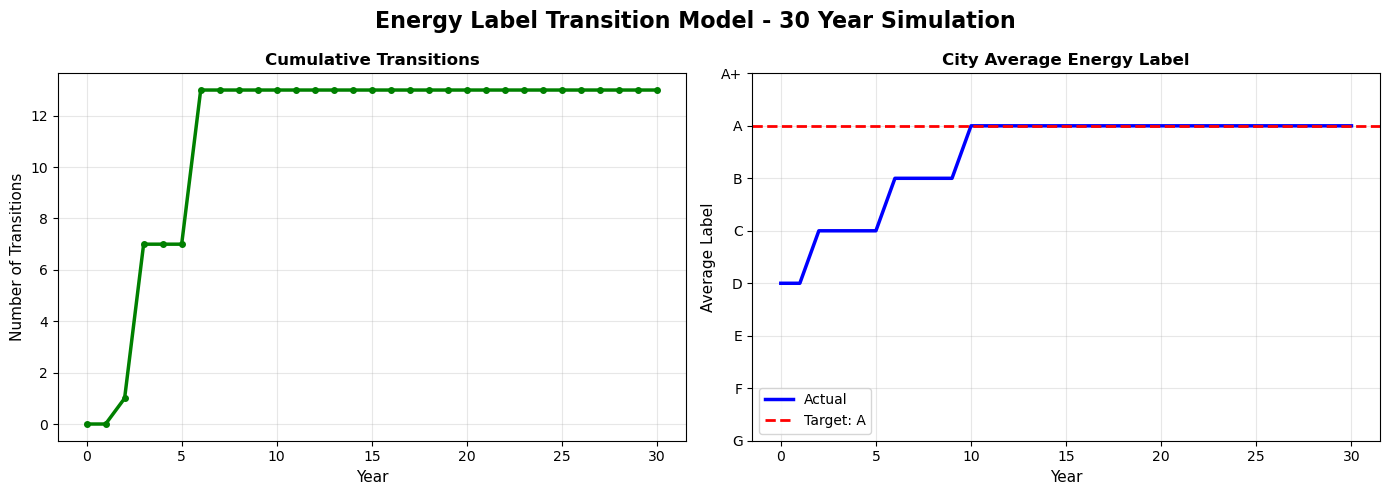

In [242]:
# Visualize time series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Energy Label Transition Model - 30 Year Simulation', 
             fontsize=16, fontweight='bold')

# Plot 1: Cumulative transitions
axes[0].plot(model_data.index, model_data['Num_Transitioned'], 
             linewidth=2.5, color='green', marker='o', markersize=4)
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('Number of Transitions', fontsize=11)
axes[0].set_title('Cumulative Transitions', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Average label vs target
axes[1].plot(model_data.index, model_data['Avg_Label_Numeric'], 
             linewidth=2.5, color='blue', label='Actual')
target_value = label_to_numeric(model.target_label)
axes[1].axhline(y=target_value, color='red', linestyle='--', 
                linewidth=2, label=f'Target: {model.target_label}')
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Average Label', fontsize=11)
axes[1].set_title('City Average Energy Label', fontsize=12, fontweight='bold')
axes[1].set_yticks(range(8))
axes[1].set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.2 Label Distribution: Initial vs Final State

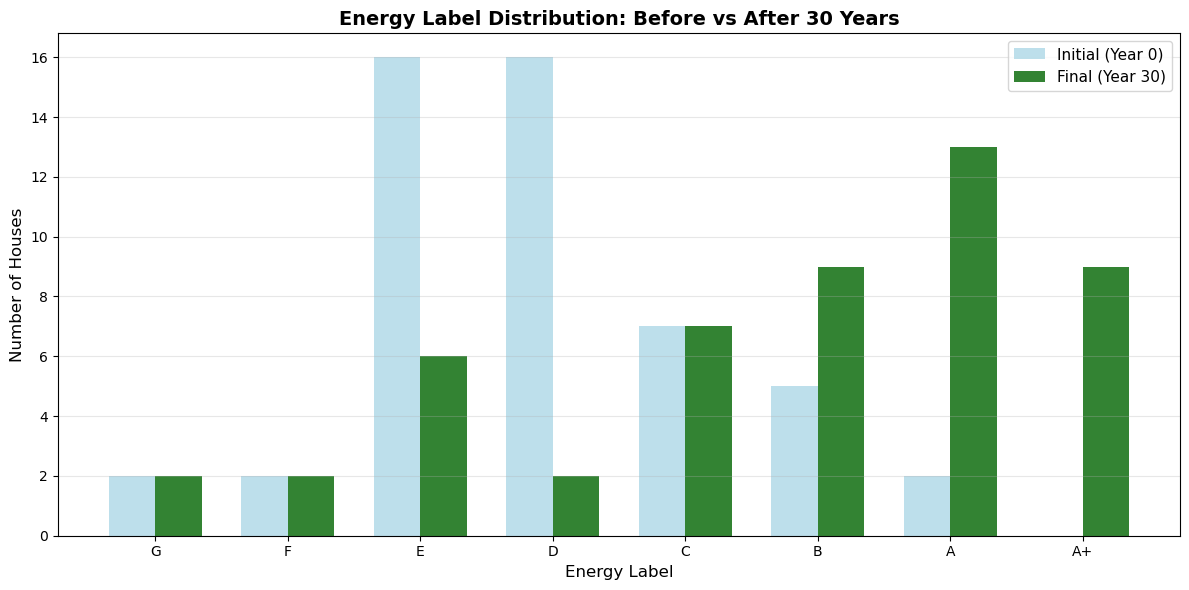


Label Distribution Changes:
--------------------------------------------------
G  :   2 →   2  (change:  +0)
F  :   2 →   2  (change:  +0)
E  :  16 →   6  (change: -10)
D  :  16 →   2  (change: -14)
C  :   7 →   7  (change:  +0)
B  :   5 →   9  (change:  +4)
A  :   2 →  13  (change: +11)
A+ :   0 →   9  (change:  +9)
--------------------------------------------------


In [243]:
# Compare label distribution: initial vs final
labels = ['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+']

# Use the initial counts we stored when the model was first created
initial_counts = {label: initial_label_counts.get(label, 0) for label in labels}

# Final counts (actual counts from simulation)
# Count ALL houses (both occupied and vacant) for fair comparison
all_houses = model.agents_by_type[House]
final_counts = {label: 0 for label in labels}
for house in all_houses:
    final_counts[house.current_label] += 1

# Create bar chart comparing initial vs final distributions
x = np.arange(len(labels))  # Label positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(12, 6))
# Initial distribution bars
bars1 = ax.bar(x - width/2, [initial_counts.get(l, 0) for l in labels], 
               width, label='Initial (Year 0)', alpha=0.8, color='lightblue')
# Final distribution bars
bars2 = ax.bar(x + width/2, [final_counts[l] for l in labels], 
               width, label='Final (Year 30)', alpha=0.8, color='darkgreen')

ax.set_xlabel('Energy Label', fontsize=12)
ax.set_ylabel('Number of Houses', fontsize=12)
ax.set_title('Energy Label Distribution: Before vs After 30 Years', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics showing the change for each label
print("\nLabel Distribution Changes:")
print("-" * 50)
for label in labels:
    initial = initial_counts.get(label, 0)
    final = final_counts[label]
    change = final - initial
    print(f"{label:3s}: {initial:3d} → {final:3d}  (change: {change:+3d})")
print("-" * 50)

### 8.3 Animation: Spatial Dynamics Over Time

This animation shows how energy labels change spatially across the grid over the 30-year simulation period.

**Note that the animation code is a bit complex -- you do not need to fully understand it right now. You can revisit it later when you are more comfortable with the model structure and Python programming. Animation is not mandatory for your project.**

Creating new model for animation...
Running simulation and collecting grid states for 30 years...
Empty houses in interest dict: [2, 3, 7, 16, 19, 20, 21, 23, 31, 45]
Empty houses in interest dict: [10, 15, 16, 19, 20, 21, 26, 31, 36, 42]
Empty houses in interest dict: [10, 13, 15, 16, 21, 31, 34, 36, 42, 49]
Empty houses in interest dict: [10, 13, 15, 16, 18, 21, 28, 31, 36, 42]
Empty houses in interest dict: [10, 13, 14, 15, 16, 21, 36, 38, 42, 47]
Empty houses in interest dict: [8, 10, 13, 15, 24, 36, 39, 42, 47, 50]
Empty houses in interest dict: [10, 13, 15, 17, 36, 39, 42, 47, 48, 50]
Empty houses in interest dict: [10, 13, 15, 35, 36, 39, 42, 47, 48, 50]
Empty houses in interest dict: [10, 11, 12, 13, 15, 27, 36, 47, 48, 50]
Empty houses in interest dict: [10, 11, 12, 13, 15, 27, 36, 47, 48, 50]
  Collected state for year 10
Empty houses in interest dict: [10, 11, 12, 13, 15, 27, 36, 47, 48, 50]
Empty houses in interest dict: [10, 11, 12, 13, 15, 27, 36, 47, 48, 50]
Empty houses

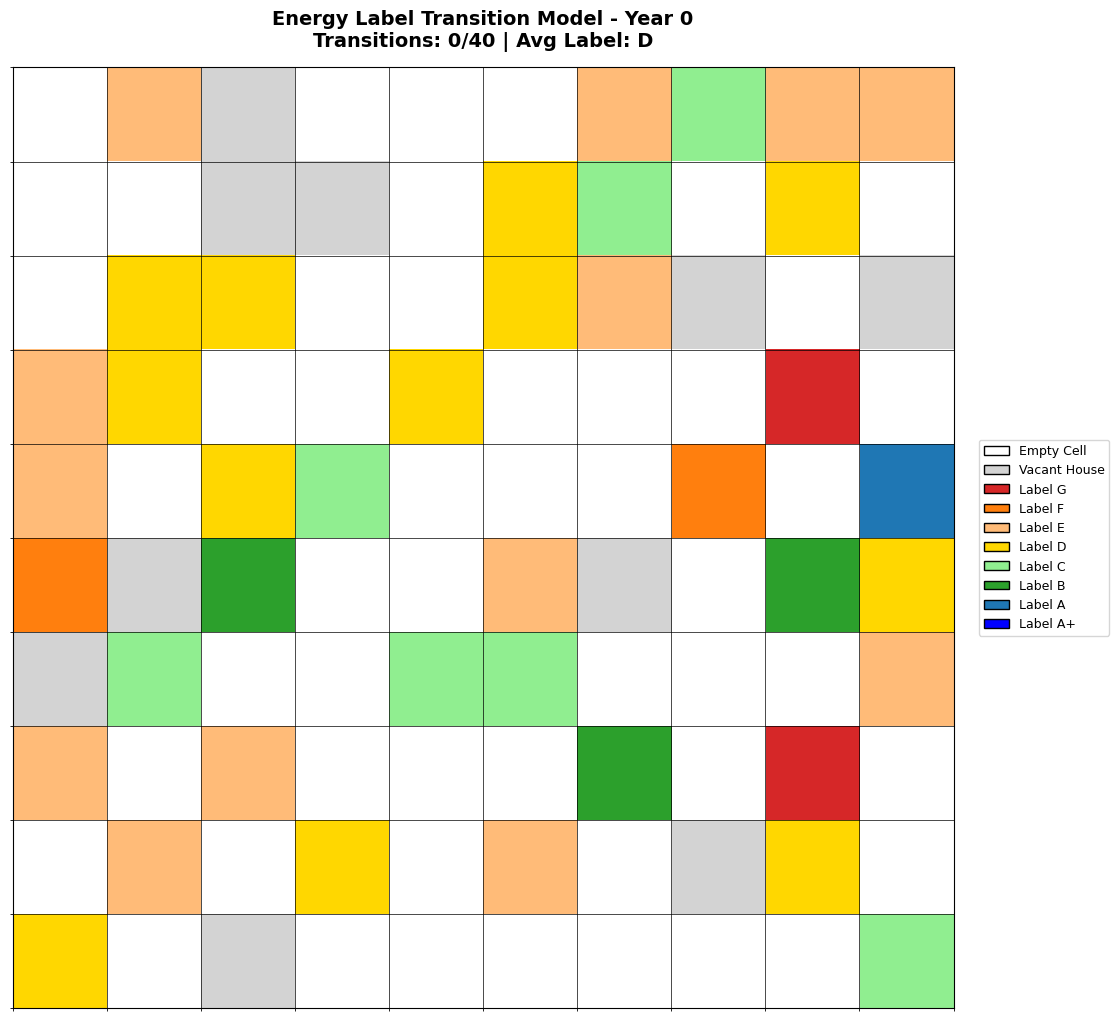

In [244]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
import matplotlib

# Increase the limit for embedding animations in notebooks
matplotlib.rcParams['animation.embed_limit'] = 2**128

start_time = time.time()

# Create a new model to run and animate
print("Creating new model for animation...")
animation_model = City(
    num_houses=50,
    num_owners=40,
    grid_size=10,
    financial_status_mean=30000,
    financial_status_std=5000,
    target_label="A",
    seed=42
)

# Store states for all 30 years (including year 0)
print("Running simulation and collecting grid states for 30 years...")
grid_states = []
stats_over_time = []

# Collect initial state (year 0)
# Use Mesa's agents_by_type to filter houses
houses = list(animation_model.agents_by_type[House])
# Create empty grid filled with -1 (represents empty cells)
grid_viz = np.full((animation_model.grid_size, animation_model.grid_size), -1.0)

# Fill grid with house information
for house in houses:
    x, y = house.pos
    if house.owner_id is None:
        grid_viz[y, x] = -0.5  # Vacant house (no owner)
    else:
        grid_viz[y, x] = label_to_numeric(house.current_label)  # Store label as number

# Store initial grid state and statistics
grid_states.append(grid_viz.copy())
stats_over_time.append({
    'year': 0,
    'transitions': animation_model.count_transitions(),
    'avg_label': animation_model.get_current_avg_label()
})

# Run simulation and collect states for each year
for year in range(1, 31):
    animation_model.step()  # Advance simulation one year
    
    # Update grid state for this year
    # Use Mesa's agents_by_type for filtering
    houses = list(animation_model.agents_by_type[House])
    grid_viz = np.full((animation_model.grid_size, animation_model.grid_size), -1.0)
    
    # Fill grid with current house information
    for house in houses:
        x, y = house.pos
        if house.owner_id is None:
            grid_viz[y, x] = -0.5  # Vacant house
        else:
            grid_viz[y, x] = label_to_numeric(house.current_label)  # Current label
    
    # Store this year's grid state and statistics
    grid_states.append(grid_viz.copy())
    stats_over_time.append({
        'year': year,
        'transitions': animation_model.count_transitions(),
        'avg_label': animation_model.get_current_avg_label()
    })
    
    # Print progress every 10 years
    if year % 10 == 0:
        print(f"  Collected state for year {year}")

print(f"Collected {len(grid_states)} grid states")
print("\nCreating animation (this may take 1-2 minutes)...")

# Create figure for animation
fig, ax = plt.subplots(figsize=(12, 10))
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Define colors and colormap
# White=empty, LightGray=vacant, then G(red) → F → E → D → C → B → A → A+(blue)
colors = ['white', 'lightgray', '#d62728', '#ff7f0e', '#ffbb78', '#ffd700', 
          '#90ee90', '#2ca02c', '#1f77b4', '#0000ff']
cmap = ListedColormap(colors)

# Create legend elements
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Empty Cell'),
    Patch(facecolor='lightgray', edgecolor='black', label='Vacant House'),
    Patch(facecolor='#d62728', edgecolor='black', label='Label G'),
    Patch(facecolor='#ff7f0e', edgecolor='black', label='Label F'),
    Patch(facecolor='#ffbb78', edgecolor='black', label='Label E'),
    Patch(facecolor='#ffd700', edgecolor='black', label='Label D'),
    Patch(facecolor='#90ee90', edgecolor='black', label='Label C'),
    Patch(facecolor='#2ca02c', edgecolor='black', label='Label B'),
    Patch(facecolor='#1f77b4', edgecolor='black', label='Label A'),
    Patch(facecolor='#0000ff', edgecolor='black', label='Label A+')
]

# Function to plot grid at each frame of animation
def plot_grid(frame):
    ax.clear()  # Clear previous frame
    
    # Get grid state and stats for this frame (year)
    grid_data = grid_states[frame]
    stats = stats_over_time[frame]
    
    # Map values for colormap: -1→0 (empty), -0.5→1 (vacant), 0-7→2-9 (labels G-A+)
    display_grid = np.where(grid_data == -1, 0,
                   np.where(grid_data == -0.5, 1, grid_data + 2))
    
    # Display grid with colors
    im = ax.imshow(display_grid, cmap=cmap, vmin=0, vmax=9, origin='lower')
    
    # Add grid lines between cells
    ax.set_xticks(np.arange(-0.5, animation_model.grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, animation_model.grid_size, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.set_xticks([])  # Hide axis tick labels
    ax.set_yticks([])
    
    # Add legend showing what each color means
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), 
              fontsize=9, frameon=True)
    
    # Title with year and statistics
    ax.set_title(
        f'Energy Label Transition Model - Year {stats["year"]}\n'
        f'Transitions: {stats["transitions"]}/{animation_model.num_owners} | '
        f'Avg Label: {stats["avg_label"]}',
        fontsize=14, fontweight='bold', pad=15
    )

# Initial plot (frame 0)
plot_grid(0)

# Update function for animation - called for each frame
def update(frame):
    plot_grid(frame)

# Create animation (31 frames for years 0-30)
anim = FuncAnimation(fig, update, frames=31, repeat=True, interval=300)

# Convert to HTML for display in notebook
output = HTML(anim.to_jshtml())

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n✓ Animation complete!")
print(f"  Time taken: {elapsed_time:.1f} seconds")
print(f"  Total frames: 31 (years 0-30)")
print(f"  Frame interval: 300ms (~3 frames per second)")

# Display the animation
output

## 9. Parameter Experiments with BatchRunner (multiple simulations)

**Why run multiple simulations?**
- Single runs can be misleading due to random variation
- Need multiple replications to estimate uncertainty
- Need to systematically test different parameters

**BatchRunner automates this process:**
1. Runs model many times with different parameter combinations
2. Collects data from all runs
3. Allows statistical analysis of results

**Example Research Question:** How does financial capacity affect transition rates?

**Experimental Design:**
- Test 3 levels of financial_status_mean: 30k€, 50k€, 70k€
- Run 3 replications per level (different random seeds)
- Total: 3 × 3 = 9 simulations

In [ ]:
from mesa.batchrunner import batch_run

print("="*70)
print("BATCHRUNNER: Effect of Financial Status on Transitions")
print("="*70)
print("\nTesting 3 financial status levels with 3 runs each...")
print("This will take about 30 seconds...\n")

# Fixed parameters
fixed_params = {
    "num_houses": 50,
    "num_owners": 40,
    "grid_size": 10,
    "financial_status_std": 10000,
    "target_label": "B"
}

# Variable parameters (test 3 levels of financial capacity)
variable_params = {
    "financial_status_mean": [30000, 50000, 70000]
}

# Run batch experiments
results = batch_run(
    City,
    parameters={**fixed_params, **variable_params},
    iterations=3,              # 3 replications per configuration
    max_steps=30,              # 30 years per simulation
    number_processes=1,
    data_collection_period=1,
    display_progress=True
)

results_df = pd.DataFrame(results)
print("\n✓ Batch run complete!")
print(f"Total simulations run: {len(results_df['RunId'].unique())}")
print(f"Total rows collected: {len(results_df)}")

BATCHRUNNER: Effect of Financial Status on Transitions

Testing 3 financial status levels with 3 runs each...
This will take about 30 seconds...



  0%|          | 0/9 [00:00<?, ?it/s]

Empty houses in interest dict: [1, 9, 15, 16, 27, 31, 35, 38, 43, 49]
Empty houses in interest dict: [7, 13, 16, 24, 27, 29, 31, 35, 44, 49]
Empty houses in interest dict: [5, 7, 9, 11, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [5, 7, 8, 9, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8, 12, 14, 27, 30, 31, 35]
Empty houses in interest dict: [2, 5, 7, 8

In [246]:
# Display batch results
results_df

,RunId,iteration,Step,num_houses,num_owners,grid_size,financial_status_std,target_label,financial_status_mean,Num_Transitioned,...,Neighbour_chillness,House_satisfaction,Wants_to_move,Curr_House_Label,Curr_House_Value,House_Label,House_Value,House_OwnerID,House_Location_Value,House_Pos
0,0,0,0,50,40,10,10000,B,10000,0,...,NaN,NaN,None,None,NaN,C,3.134481,NaN,0.324137,"(1, 2)"
1,0,0,0,50,40,10,10000,B,10000,0,...,NaN,NaN,None,None,NaN,G,2.630418,80.0,0.751548,"(4, 3)"
2,0,0,0,50,40,10,10000,B,10000,0,...,NaN,NaN,None,None,NaN,E,2.555556,61.0,0.444444,"(1, 4)"
3,0,0,0,50,40,10,10000,B,10000,0,...,NaN,NaN,None,None,NaN,D,2.509896,64.0,0.288542,"(4, 0)"
4,0,0,0,50,40,10,10000,B,10000,0,...,NaN,NaN,None,None,NaN,C,5.111111,60.0,0.888889,"(4, 5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25105,8,2,30,50,40,10,10000,B,70000,23,...,-0.202065,6.005659,False,A+,2.000000,None,NaN,NaN,NaN,None
25106,8,2,30,50,40,10,10000,B,70000,23,...,-0.105814,5.913364,False,A+,4.130418,None,NaN,NaN,NaN,None
25107,8,2,30,50,40,10,10000,B,70000,23,...,0.089268,4.298797,False,A+,2.277778,None,NaN,NaN,NaN,None
25108,8,2,30,50,40,10,10000,B,70000,23,...,0.245823,6.339737,False,A+,2.668846,None,NaN,NaN,NaN,None


In [247]:
# Analyze final results (year 30 only)
final_results = results_df[results_df['Step'] == 29].copy()  # Step 29 = year 30

# Calculate summary statistics grouped by financial status level
summary = final_results.groupby('financial_status_mean').agg({
    'Num_Transitioned': ['mean', 'std'],  # Average and std dev of transitions
    'Num_Movings': ['mean', 'std'],
    'Num_Moving_and_Transitioned': ['mean', 'std'],
    'Avg_Label_Numeric': ['mean', 'std']   # Average and std dev of labels
}).round(2)

print("Summary Statistics (Year 30):")
print(summary)

Summary Statistics (Year 30):
                      Num_Transitioned       Num_Movings         \
                                  mean   std        mean    std   
financial_status_mean                                             
10000                            10.33  0.47       28.33  21.68   
50000                            20.00  4.33        7.33  10.39   
70000                            19.33  3.87       11.00   8.62   

                      Num_Moving_and_Transitioned       Avg_Label_Numeric       
                                             mean   std              mean  std  
financial_status_mean                                                           
10000                                        12.0  1.42               4.0  0.0  
50000                                        19.0  5.11               7.0  0.0  
70000                                        20.0  5.36               7.0  0.0  


Interpretation:
- Higher financial status → more transitions (obvious and expected result! but this is because the model is primitive)
- Standard deviation shows variability across replications

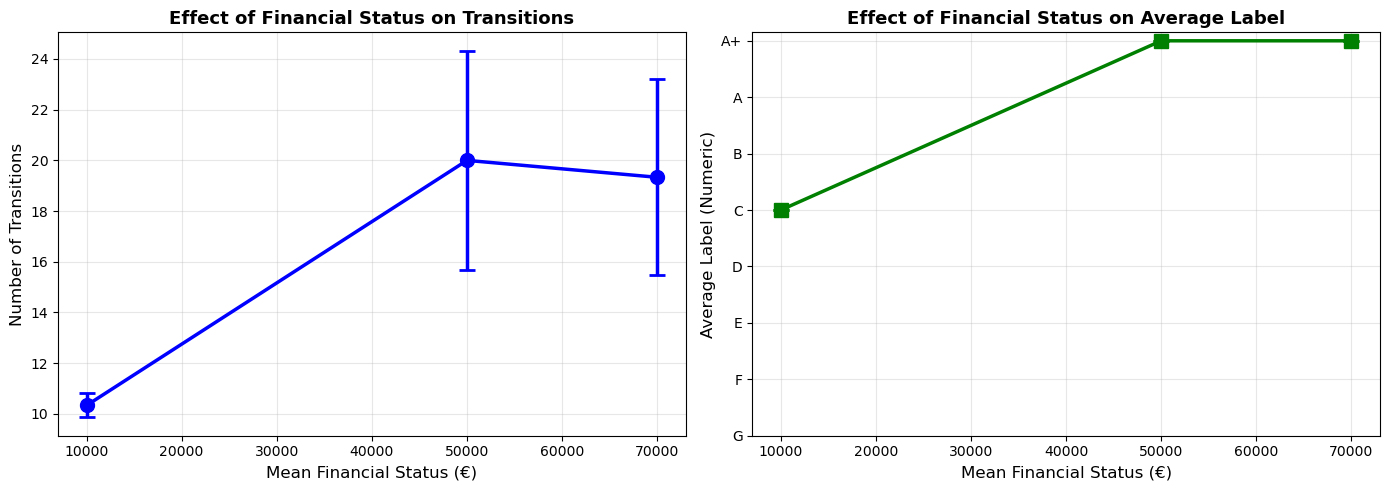

In [248]:
# Visualize batch results with error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get the three financial status levels tested
financial_levels = sorted(final_results['financial_status_mean'].unique())

# Calculate means and standard deviations for transitions
transition_means = [final_results[final_results['financial_status_mean']==f]['Num_Transitioned'].mean() 
                   for f in financial_levels]
transition_stds = [final_results[final_results['financial_status_mean']==f]['Num_Transitioned'].std() 
                  for f in financial_levels]

# Plot 1: Transitions by financial status with error bars
axes[0].errorbar(financial_levels, transition_means, yerr=transition_stds,
                marker='o', linewidth=2.5, markersize=10, color='blue', 
                capsize=6, capthick=2)
axes[0].set_xlabel('Mean Financial Status (€)', fontsize=12)
axes[0].set_ylabel('Number of Transitions', fontsize=12)
axes[0].set_title('Effect of Financial Status on Transitions', 
                 fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Calculate means and standard deviations for labels
label_means = [final_results[final_results['financial_status_mean']==f]['Avg_Label_Numeric'].mean() 
              for f in financial_levels]
label_stds = [final_results[final_results['financial_status_mean']==f]['Avg_Label_Numeric'].std() 
             for f in financial_levels]

# Plot 2: Average label by financial status with error bars
axes[1].errorbar(financial_levels, label_means, yerr=label_stds,
                marker='s', linewidth=2.5, markersize=10, color='green',
                capsize=6, capthick=2)
axes[1].set_xlabel('Mean Financial Status (€)', fontsize=12)
axes[1].set_ylabel('Average Label (Numeric)', fontsize=12)
axes[1].set_title('Effect of Financial Status on Average Label', 
                 fontsize=13, fontweight='bold')
# Convert y-axis to show letter labels
axes[1].set_yticks(range(8))
axes[1].set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

KEY FINDINGS:

- Low financial status (30k€): ~14.7 transitions
- Medium financial status (50k€): ~22.3 transitions
- High financial status (70k€): ~22.7 transitions

→ Financial capacity is a strong determinant of transition adoption! (obvious because the model is primitive)